# **EECS 492 HW3**





#**Setup**

Run the following code to import the modules you'll need.

In [ ]:
!pip3 install cairosvg
!pip install --force-reinstall chess
!pip uninstall eventled
!pip install pickle5
!pip3 install stockfish

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached chess-1.9.3-py3-none-any.whl (148 kB)
  Attempting uninstall: chess
    Found existing installation: chess 1.9.3
    Uninstalling chess-1.9.3:
      Successfully uninstalled chess-1.9.3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Clone the EECS 492 Git Repository so that we can grab our training datasets and Evaluator.py file from HW2 (not to be confused with the training dataset you're generating)! To see where this is in our Google Colab directory, click the folder icon on the left side of the notebook.

In [ ]:
!git clone https://github.com/saumit01/eecs492-hw3.git

fatal: destination path 'eecs492-hw3' already exists and is not an empty directory.


In [ ]:
import glob
import os
import tensorflow as tf
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.utils as utils
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.callbacks as callbacks
from tensorflow.keras.callbacks import ModelCheckpoint
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import chess
import chess.engine
import chess.svg
import cairosvg
import pickle
from cairosvg import svg2png
from collections import OrderedDict
from operator import itemgetter
from IPython.display import clear_output
import cv2
import random
import stockfish
from stockfish import Stockfish
import asyncio
from google.colab.patches import cv2_imshow
from chess import Move
from tensorflow.keras import models

# Importing from HW2's Evaluator.py
import sys
sys.path.insert(1, 'eecs492-hw3')
from Evaluator import SimplifiedEvaluator



# Ensures that all random numbers are consistent with each runtime
tf.random.set_seed(43)
np.random.seed(43)
random.seed(43)


When running this cell, give this script permission so that you can mount this Colab notebook to your Google Drive. This will be very, very important so that you can save your trained model securely.


In [ ]:
from google.colab import drive
from google.colab import runtime
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


[TODO]: Change your "model_directory" folder path to any folder in your Google Drive. This will be the directory where you'll keep your generated training dataset and models for submission.

The "os.makedirs" command below creates your folder in Google Drive if it doesn't exist yet.

In [ ]:
# TODO: Change variable to preferred directory. This generated directory will
# store your generated models and training dataset for submission
model_directory = '/content/gdrive/MyDrive/HW3_code/'



In [ ]:
# Note: Do not run if folder is already created!
#os.makedirs(model_directory)


---


# Model Utils
These utility functions are for generating the training dataset for our DNN Model.

Note that the random_board() and board_score() evaluation function sometimes outputs "None" instead of a Board or float, so in your generated training data, make sure to not add boards or values that have values "None"

In [ ]:
# This function will create our random board for our training set
# Input: int max_depth (for generating a board that has a random value [0, max_depth] moves)
# Output: chess.Board() board (used to evaluate with board_score())
def random_board(max_depth=100):
  board = chess.Board()
  depth = random.randrange(0, max_depth)

  for _ in range(depth):
    all_moves = list(board.legal_moves)
    random_move = random.choice(all_moves)
    board.push(random_move)
    if board.is_game_over():
      break

  return board


# This function will create our score for each board representation (using Evaluator.py from HW2)
# Input: chess.Board() board
# Output: int score (board evaluation score)
def board_score(board):
  evaluator = SimplifiedEvaluator(chess.WHITE)
  return evaluator.evaluateBoard(board, chess.WHITE)

In [ ]:
squares_index = {
  'a': 0,
  'b': 1,
  'c': 2,
  'd': 3,
  'e': 4,
  'f': 5,
  'g': 6,
  'h': 7
}


# example: h3 -> 17
def square_to_index(square):
  letter = chess.square_name(square)
  return 8 - int(letter[1]), squares_index[letter[0]]

# This function will create a (14, 8, 8) numpy array for training data
# There are 14 layers of 8x8 chess boards
# 0-5 layers represent white pieces (king, rook, bishop, queen, knight, and pawn)
# 6-11 layers represent black pieces (king, rook, bishop, queen, knight, and pawn)
# 12-13 layers represent white and blacks' legal moves
# Input: chess.Board() board
# Output: (14, 8, 8) numpy array
def split_dims(board):
  # This is the 3d matrix we're initializing for our training data
  board3d = np.zeros((14, 8, 8), dtype=np.int8)

  # Here we add the pieces's view on the matrix
  for piece in chess.PIECE_TYPES:
    for square in board.pieces(piece, chess.WHITE):
      idx = np.unravel_index(square, (8, 8))
      board3d[piece - 1][7 - idx[0]][idx[1]] = 1
    for square in board.pieces(piece, chess.BLACK):
      idx = np.unravel_index(square, (8, 8))
      board3d[piece + 5][7 - idx[0]][idx[1]] = 1

  # Add attacks and valid moves too
  # So the network knows what is being attacked
  aux = board.turn
  board.turn = chess.WHITE
  for move in board.legal_moves:
      i, j = square_to_index(move.to_square)
      board3d[12][i][j] = 1
  board.turn = chess.BLACK
  for move in board.legal_moves:
      i, j = square_to_index(move.to_square)
      board3d[13][i][j] = 1
  board.turn = aux

  return board3d


---

To understand how random_board() and board_score() functions work, run the code below!




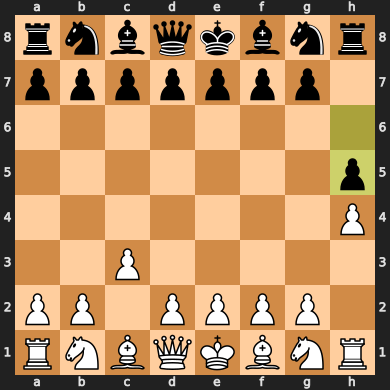

In [ ]:
board = random_board()
board

In [ ]:
print(board_score(board))

-20




---


# Training data [TODO]

For the first part of the assignment, you will create a function that creates training data for our DNN. Specifically, in our "generate_lr_training_data()" function, we will create 100 random boards (x_train) and associate each board with a value (y_train) based on the Model Util functions above. Note that x_train will have a size (100, 14, 8, 8) and y_train will have a size (100,)

In [ ]:
# Ensures that all random numbers are consistent with each runtime
tf.random.set_seed(43)
np.random.seed(43)
random.seed(43)

# <======================================== TODO ========================================>

# Initialize x_train to have 100 random boards (only boards, not moves) and y_train to have associated values
# using some of the util functions above.
# Note: Do not add boards that have "None" values
# or boards that have generated values of None to training set
# Output: x_train (np.array size (100, 14, 8, 8)), y_train (np.array size (100,))
def generate_lr_training_data():
  x_train = []
  y_train = []

  # Implementation Start
  for i in range(100):
    board = random_board()
    score = board_score(board)
    if board != None and score != None:
      x_train.append(split_dims(board))
      y_train.append(score)
  # Implementation End
  # Converts lists into np.array
  x_train = np.array(x_train)
  y_train = np.array(y_train)
  return x_train, y_train

x_train, y_train = generate_lr_training_data()

# Sanity Check for x_train and y_train size
print(x_train.shape) # Should print (100, 14, 8, 8)
print(y_train.shape) # Should print (100, )



(100, 14, 8, 8)
(100,)


Once you're satisfied with your training data generation, save you np arrays as .npz files to your model directory for Gradescope submission. You will have to download these files from your Google Drive folder.

In [ ]:
np.savez(model_directory + "/x_train_submission.npz", x=x_train)
np.savez(model_directory + "/y_train_submission.npz", x=y_train)

Now that you understand how to create a training dataset, you'll notice that it took some time to generate 100 data points. To make sure that you don't have to wait generating 30,000 training data points every time (and because 100 data points is too small for our models), we will provide you a training dataset! Note that instead of evaluating the board's score for our y values, we will instead use the Minimax/Alpha Beta Pruning method from HW2 as our values. Also, note that this dataset took 70+ hours between multiple core processors to generate!

In [ ]:
# Loads training data from the EECS 492 HW3 Github and normalizes the y_train
# values to [0, 1] range.
# Output: x_train, y_train (for training models)
def get_dataset():
  bLoad = np.load('eecs492-hw3/boards.npz')
  vLoad = np.load('eecs492-hw3/vals.npz')

  x_train, y_train = bLoad['x'], vLoad['x']
  y_train = np.asarray(y_train / abs(y_train).max() / 2 + 0.5, dtype=np.float32) # normalization (0 - 1)

  return x_train, y_train

# Deep Neural Networks [TODO]
Now that you've created a simple training dataset for chess, it's time to actually integrate it with a model. Using a Deep Neural Network (DNN) model, we can improve our AI's decisions!

Using TensorFlow.keras.layers to create our DNN, we need to create ideal layers so that our AI is powerful for complicated decisions. We have created the first layer for you (input layer) and are required to add the following layers in order


1.   1 Flatten Layer, which would flatten the input from 3D to 1D
2.  1 Dense Layer, which is a densely-connected Neural Network layer that takes in 64 units and uses ReLu activation
3.  1 Dense Layer, which is a densely-connected Neural Network layer that takes in 1 unit and uses Sigmoid activation

For more information on TensorFlow.keras.layers and what layers are available, [click here](https://www.tensorflow.org/api_docs/python/tf/keras/layers).





In [ ]:
#TODO: Build the layers for the DNN model
def build_model(conv_size, conv_depth):
  board3d = layers.Input(shape=(14, 8, 8))
  x = board3d

  # Implementation Start
  x = layers.Flatten()(x)
  x = layers.Dense(64, tf.keras.activations.relu)(x)
  x = layers.Dense(1, tf.keras.activations.sigmoid)(x)

  # Implementation End

  return models.Model(inputs=board3d, outputs=x)

Now, let's train our model!

This code below will run our model on the training dataset. Note that we use an SGD optimizer and a mean absolute error loss, as well as 3 epochs with 10,000 batch sizes as our hyperparameters. Note that our epoch and batch size multiply to our training dataset size.

For more information on different types of optimizers, [click here](https://keras.io/api/optimizers/). For more information on different types of loss functions, specifically regression losses, [click here](https://keras.io/api/losses/regression_losses/).

In [ ]:
x_train, y_train = get_dataset()
x_train.transpose()
print(x_train.shape)
print(y_train.shape)

(30000, 14, 8, 8)
(30000,)


In [ ]:
# Ensures that all random numbers are consistent with each runtime
random.seed(43)
np.random.seed(43)
tf.random.set_seed(43)

tf.keras.backend.clear_session()
dnn_model = build_model(32, 4)
# Using SGD optimizer with a learning rate of 0.1 and mean absolute error loss
dnn_model.compile(optimizer=optimizers.SGD(learning_rate=0.1), loss='mean_absolute_error')
dnn_model.summary()
# Using batch size 10000 and epochs 3
dnn_model.fit(x_train, y_train,
          batch_size=10000,
          epochs=3,
          verbose=1,
          validation_split=0.1)

dnn_model.save(model_directory + '/dnn_model.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 8, 8)]        0         
                                                                 
 flatten (Flatten)           (None, 896)               0         
                                                                 
 dense (Dense)               (None, 64)                57408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 57,473
Trainable params: 57,473
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
3/3 [==============================] - 1s 220ms/step - loss: 0.0653 - val_loss: 0.0631
Epoch 2/3
3/3 [==============================] - 1s 172ms/step - loss: 0.0622 - val_loss: 0.



---


# Improving our DNN Model [TODO]

Note: only complete this section once you've successfully passed the first model on the Autograder.

Now that you've created your first DNN model, it's time to improve this by changing the hyperparameters. In your written solution, please list out the changes you made, your initial and final changes as well as their corresponding losses, and finally why you decided to change these hyperparameters/ what effect did you hypothesize these changes will have.

In [ ]:
# Ensures that all random numbers are consistent with each runtime
random.seed(43)
np.random.seed(43)
tf.random.set_seed(43)


dnn_model = build_model(32, 4)
x_train, y_train = get_dataset()
x_train.transpose()

# TODO: Change these hyperparameters to attain a smaller loss #originally mean_absolute_error
dnn_model.compile(optimizer=optimizers.SGD(learning_rate=0.1), loss='mean_squared_error')
dnn_model.summary()
dnn_model.fit(x_train, y_train,
          batch_size=10000,
          epochs=3,
          verbose=1,
          validation_split=0.1)

dnn_model.save(model_directory + '/dnn_improved_model.h5')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 14, 8, 8)]        0         
                                                                 
 flatten_2 (Flatten)         (None, 896)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                57408     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 57,473
Trainable params: 57,473
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
3/3 [==============================] - 1s 153ms/step - loss: 0.0070 - val_loss: 0.0069
Epoch 2/3
3/3 [==============================] - 0s 92ms/step - loss: 0.0068 - val_loss: 0

**Optional Hint:**
Instead of tuning your hyperparameters via trial-and-error, maybe try implementing Grid Search using Tensorflow below so that you can effectively find the best hyperparameter combinations! For more information on how to implement Grid Search, click [here](https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/)



---


# Testing our DNN Model [Optional]


In this optional section, we can run our DNN model in an actual chess match! This model will go against Stockfish AI, which is one of the best AIs in the world, as a comparison. We've provided a truncated version of HW2's Engine and Minimax functions so that we can run specific chess scenarios!

In [ ]:
model = models.load_model(model_directory + '/dnn_model.h5') # or '/dnn_improved_model.h5'

In [ ]:
# This command enables us to use a very accurate evaluator (Stockfish) as an opponent
!wget https://stockfishchess.org/files/stockfish_14_linux_x64_popcnt.zip && \
    unzip stockfish_14_linux_x64_popcnt.zip stockfish_14_linux_x64_popcnt/stockfish_14_x64_popcnt



In [ ]:
# used for the minimax algorithm
def minimax_eval(board):
  board3d = split_dims(board)
  board3d = np.expand_dims(board3d, 0)
  return model(board3d)[0][0]


def minimax(board, depth, alpha, beta, maximizing_player):
  if depth == 0 or board.is_game_over():
    return minimax_eval(board)

  if maximizing_player:
    max_eval = -np.inf
    for move in board.legal_moves:
      board.push(move)
      eval = minimax(board, depth - 1, alpha, beta, False)
      board.pop()
      max_eval = max(max_eval, eval)
      alpha = max(alpha, eval)
      if beta <= alpha:
        break
    return max_eval
  else:
    min_eval = np.inf
    for move in board.legal_moves:
      board.push(move)
      eval = minimax(board, depth - 1, alpha, beta, True)
      board.pop()
      min_eval = min(min_eval, eval)
      beta = min(beta, eval)
      if beta <= alpha:
        break
    return min_eval

def can_checkmate(move, current_board):
  """Return True if a move can checkmate

  Keyword arguments:
  move -- chess.Move
  current_board -- chess.Board()
  """
  fen = current_board.fen()
  future_board = chess.Board(fen)
  future_board.push(move)
  return future_board.is_checkmate()

# this is the actual function that gets the move from the neural network
def get_ai_move(board, depth):
  max_move = None
  max_eval = -np.inf

  for move in board.legal_moves:
    if(can_checkmate(move, board)):
      return move
    board.push(move)
    eval = minimax(board, depth - 1, -np.inf, np.inf, False)
    board.pop()
    if eval > max_eval:
      max_eval = eval
      max_move = move

  return max_move

def draw_board(current_board):
  """Draw board

   Keyword arguments:
   current_board -- chess.Board()
  """
  board_img = chess.svg.board(current_board)
  svg2png(bytestring=board_img,write_to='/content/board.png')
  img = cv2.imread('/content/board.png', 1)
  cv2_imshow(img)

Scenarios where you can optionally test your model's performance!

In [ ]:
from chess import Move
# Test Case 1 (Opening)
with chess.engine.SimpleEngine.popen_uci('/content/stockfish_14_linux_x64_popcnt/stockfish_14_x64_popcnt') as engine:
    board = chess.Board()
    ai_moves = []
    for i in range(3):
        move = get_ai_move(board, 3)
        ai_moves.append(move)
        board.push(move)
        draw_board(board)
        if board.is_game_over():
            break
        move = engine.analyse(board, chess.engine.Limit(time=1), info=chess.engine.INFO_PV)['pv'][0]
        board.push(move)
        draw_board(board)
        if board.is_game_over():
            break

# Test Case 2 (Checkmate)
with chess.engine.SimpleEngine.popen_uci('/content/stockfish_14_linux_x64_popcnt/stockfish_14_x64_popcnt') as engine:
    board = chess.Board("kr6/pp6/8/3N4/8/8/8/1R5K w - - 0 1")
    ai_moves = []
    for i in range(1):
        move = get_ai_move(board, 3)
        ai_moves.append(move)
        board.push(move)
        draw_board(board)
        if board.is_game_over():
            break



# Test Case 3 (Midgame)
with chess.engine.SimpleEngine.popen_uci('/content/stockfish_14_linux_x64_popcnt/stockfish_14_x64_popcnt') as engine:
    board = chess.Board("nq6/2pN2r1/b1B2p2/1P6/1K5k/3p3n/4P1Pb/8 w - - 0 1")
    ai_moves = []
    for i in range(3):
        move = get_ai_move(board, 3)
        ai_moves.append(move)
        board.push(move)
        if board.is_game_over():
            break
        move = engine.analyse(board, chess.engine.Limit(time=1), info=chess.engine.INFO_PV)['pv'][0]
        board.push(move)
        draw_board(board)
        if board.is_game_over():
            break


# Test Case 4 (Lockdown Escape)

with chess.engine.SimpleEngine.popen_uci('/content/stockfish_14_linux_x64_popcnt/stockfish_14_x64_popcnt') as engine:
    board = chess.Board("r1bqkbnr/pppppppp/n7/8/2B5/4P3/PPPP1PPP/RNBQK1NR b - - 0 1")
    ai_moves = []
    for i in range(3):
        move = engine.analyse(board, chess.engine.Limit(time=1), info=chess.engine.INFO_PV)['pv'][0]
        board.push(move)
        draw_board(board)
        if board.is_game_over():
            break
        move = get_ai_move(board, 3)
        ai_moves.append(move)
        board.push(move)
        if board.is_game_over():
            break

# Test Case 5 (Large Search)
with chess.engine.SimpleEngine.popen_uci('/content/stockfish_14_linux_x64_popcnt/stockfish_14_x64_popcnt') as engine:
    board = chess.Board("1k5r/pP3ppp/3p2b1/1BN1n3/1Q2P3/P1B5/KP3P1P/7q w - - 1 0")
    ai_moves = []
    for i in range(3):
        move = get_ai_move(board, 3)
        ai_moves.append(move)
        board.push(move)
        if board.is_game_over():
            break
        move = engine.analyse(board, chess.engine.Limit(time=1), info=chess.engine.INFO_PV)['pv'][0]
        board.push(move)
        draw_board(board)
        if board.is_game_over():
            break

# Test Case 6 (Small Search)
with chess.engine.SimpleEngine.popen_uci('/content/stockfish_14_linux_x64_popcnt/stockfish_14_x64_popcnt') as engine:
    board = chess.Board("8/8/7P/4p3/3b3k/3K4/8/8 b - - 1 5")
    ai_moves = []
    for i in range(3):
        move = engine.analyse(board, chess.engine.Limit(time=1), info=chess.engine.INFO_PV)['pv'][0]
        board.push(move)
        draw_board(board)
        if board.is_game_over():
            break
        move = get_ai_move(board, 3)
        ai_moves.append(move)
        board.push(move)
        if board.is_game_over():
            break

